In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# import emukit
import GPy
# from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
# from emukit.core.initial_designs.random_design import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

# from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
# from emukit.core.acquisition import IntegratedHyperParameterAcquisition

from rgpe import compute_rank_weights

In [2]:

import numpy as np
from scipy.spatial.distance import cdist
from emukit.core.initial_designs.latin_design import LatinDesign

def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results

def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original




# def get_closest_array(x_init, X_all):
#     # 计算 x_init 中每个点与 X_all 中所有点之间的距离
#     distances = cdist(x_init, X_all)   
#     # 找到每个点最近的索引
#     closest_indices = np.argmin(distances, axis=1)    
#     # 根据索引获取最近的点
#     closest_array = X_all[closest_indices]  
#     return closest_array

def get_closest_array(x_init, X_all):
    X_all_copy = X_all.copy()
    closest_array = []
    
    for x in x_init:
        # 计算 x 与 X_all_copy 中所有点之间的距离
        distances = cdist([x], X_all_copy)[0]
        # 找到最近的索引
        closest_index = np.argmin(distances)
        # 根据索引获取最近的点
        closest_point = X_all_copy[closest_index]
        # 将最近的点添加到结果数组中
        closest_array.append(closest_point)
        # 从 X_all_copy 中移除这个点
        X_all_copy = np.delete(X_all_copy, closest_index, axis=0)
        
    return np.array(closest_array)


# # 计算两个点之间的欧几里得距离
# def euclidean_distance(point1, point2):
#     return np.sqrt(np.sum((point1 - point2) ** 2))

# # 找到X_all中与x_init每个元素最近的点
# def get_closest_array(x_init, X_all):
#     closest_array = []
#     for point in x_init:
#         distances = np.array([euclidean_distance(point, x) for x in X_all])
#         closest_idx = distances.argmin()
#         closest_array.append(X_all[closest_idx])
#     return np.array(closest_array)

def create_latin_design(X_all):
 
    x_array = [X_all[:, i] for i in range(X_all.shape[1])]
    
    num_columns = X_all.shape[1]
    parameter_space = ParameterSpace([ContinuousParameter(f'x{i+1}', 0, 1) for i in range(num_columns)])
    design = LatinDesign(parameter_space)
    
    return x_array , design



# 导入目标任务

In [4]:
import pandas as pd
import numpy as np
import os


folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\matminner_processed' 
file_path = os.path.join(folder_path, 'Ti.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

# folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
# file_path = os.path.join(folder_path, 'S2_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

# Virtual_ti


df = pd.read_excel(file_path)

#去除存在nan的点
# nan_indices = np.isnan(Y)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]
print(df.shape)

X_all = df.iloc[:, :-1].values  
Y_all = - df.iloc[:, -1].values   

print(X_all.shape,Y_all.shape)

(88, 10)
(88, 9) (88,)


# x和y预处理

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ----------------------------------------minmax
# min_max_scaler = MinMaxScaler()
# X_all = min_max_scaler.fit_transform(X_all)
# ----------------------------------------no minmax
X_all =X_all

#去除存在nan的点
nan_indices = np.isnan(Y_all)
true_indices = np.where(nan_indices)[0]
print("nan 的索引:", true_indices)

X_all = X_all[~nan_indices.flatten()]
Y_all = Y_all[~nan_indices.flatten()]

print(X_all.shape,Y_all.shape)
y_min = np.nanmin(Y_all)
y_min

nan 的索引: []
(88, 9) (88,)


-8.470101583882409

# 导入源模型

In [15]:

import pickle

# 定义要加载的模型名称列表


# Fe  Co  Ni  others  Co_plus
file_name = "Fe" 
model_names_to_load = ['Fe.pkl']
folder_path = r'C:\Users\13282\Desktop\papercode\trasfer\base_model\Alloy\matminer' 

# file_name = "s1_1" 
# model_names_to_load = ['s1.pkl']
# folder_path = r'C:\Users\13282\Desktop\papercode\trasfer\base_model\Alloy\original' 


loaded_models = {}
for model_name in model_names_to_load:
    model_filename = os.path.join(folder_path, model_name)
    with open(model_filename, 'rb') as f:
        loaded_models[model_name] = pickle.load(f)
base_models = []
for model_name in model_names_to_load:
    base_models.append(loaded_models[model_name])

    





        

# 设置参数

In [16]:
from emukit.bayesian_optimization.acquisitions import EI_transfer

from emukit.bayesian_optimization.acquisitions import SampleMaxVariance, SampleMinEuclideanDistance, \
                                                SampleVarianceEuclideanDistance,  SampleYDistance

import os



n_loop = 40        #循环求均值次数，也即整个流程重复次数
maxiter = 60       #模型迭代次数

rdm_sample = 5

# num_x_init = 20

model_var = 0.1
num_restarts = 5
bs = 1
top = 1



# rgpe（taf）的一些参数
n_samples = 1000    #模型抽样个数
rng = np.random.RandomState(4)  #生成随机数种子
sampling_mode = 'bootstrap'
weight_dilution_strategy = 'probabilistic-ld'
Optimization_horizon =  maxiter 

# 开始加入迁移的优化任务

In [17]:
def normalize_array(Y_all):
    # 判断数组中的所有元素是否相同
    if np.all(Y_all == Y_all[0]):
        # 如果所有元素相同，将所有值归一化为0
        Y_all_nom = np.zeros_like(Y_all)
    else:
        # 如果元素不全相同，进行归一化操作
        Y_all_nom = (Y_all - np.min(Y_all)) / (np.max(Y_all) - np.min(Y_all))
    
    return Y_all_nom

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import tqdm

import logging
logging.getLogger('variance').setLevel(logging.ERROR)
logging.getLogger('lengthscale').setLevel(logging.ERROR)

var_array , design = create_latin_design(X_all)


df_min_y= pd.DataFrame()
df_wt = pd.DataFrame()

# df_w1 = pd.DataFrame()
# df_w2 = pd.DataFrame()
# df_w3 = pd.DataFrame()
# df_w4 = pd.DataFrame()

first_iteration = True  # 初始化布尔变量，表示是否是第一次迭代

for tri in tqdm.tqdm(range(n_loop), desc="Loop Progress"): 
    
    # 进行初始选点
#     np.random.seed(42)  # 设置随机种子以确保结果可重现
#     x_init = design.get_samples(lhs_sample)                        
#     x_init_original = get_closest_array(x_denormalizer(x_init, var_array),X_all)
#     X = x_init_original
        
    random_indices = np.random.choice(X_all.shape[0], rdm_sample , replace=False)  
    X = X_all[random_indices] 

#     Y = find_y_by_x(X, X_all, Y_all)
#     # 初始化模型
#     input_dim = len(X[0])
#     ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
#     model_gpy = GPRegression(X,Y, ker)
#     emukit_model = GPyModelWrapper(model_gpy)  
    
#     for i in range( num_x_init - lhs_sample):
        
#         select_acquisition = SampleMinEuclideanDistance(emukit_model)   
#         acq_plot = select_acquisition.evaluate(X_all)
#         select_acquisition_nom = (acq_plot - np.min(acq_plot)) / (np.max(acq_plot) - np.min(acq_plot))
#         #将已经采样点的获取函数值设为0
#         for x_row in X:
#             indices = np.where(np.all(X_all == x_row, axis=1))[0]
#             select_acquisition_nom[indices] = 0
            
#         sort_index = np.argsort(select_acquisition_nom, axis =0)
#         x_new = []
#         for i in sort_index[-top:]:
#                 x_new.append(X_all[i][0])
#         x_new=np.array(x_new)
#         y_new = find_y_by_x(x_new, X_all, Y_all)
        
#         X = np.append(X, x_new, axis=0)
#         Y = np.append(Y, y_new, axis=0)
        
#         model_gpy = GPRegression(X, Y, ker)
#         emukit_model = GPyModelWrapper(model_gpy)   

# 初始化模型
    Y = find_y_by_x(X, X_all, Y_all)
    input_dim = len(X[0])
    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)# 
    ker.randomize()
    ker.lengthscale.constrain_bounded(0.01, 10)
    ker.variance.constrain_bounded(1e-2, 1e4) 
    model_gpy = GPRegression(X,Y, ker)
    model_gpy.Gaussian_noise.variance = model_var**2
    model_gpy.Gaussian_noise.variance.fix()
    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
    emukit_model = GPyModelWrapper(model_gpy)   
    
    
#进行优化迭代
    w_t_all = []
#     w_s_1 = []
#     w_s_2 = []
#     w_s_3 = []
#     w_s_4 = []
   
    min_y = []
    
    for i in range(maxiter):

        target_model = copy.deepcopy(emukit_model)
        params = {
            "train_x": X,
            "train_y": Y,
            "base_models": base_models,
            "target_model": target_model,
            "num_samples": n_samples,
            "sampling_mode": sampling_mode,
            "weight_dilution_strategy": weight_dilution_strategy,
            "number_of_function_evaluations": Optimization_horizon,
            "rng": rng,
            "plot_target_pred_vs_true": False
        }


        weight_list = compute_rank_weights(**params)
        
        w_s =  weight_list[:-1]
        w_t = weight_list[-1]  
#         w_1 = weight_list[0]
#         w_2 = weight_list[1]
#         w_3 = weight_list[2]
#         w_4 = weight_list[3]

        nlcb_list = []
# ----------------------------------------------------------------------------------  ei      
#         for model in base_models:
#             nlcb_acquisition = EI_transfer(model, Y_target=Y)
#             nlcb = nlcb_acquisition.evaluate(X_all)
#             nlcb_nom = normalize_array(nlcb)
#             nlcb_list.append(nlcb_nom)

#         source_acquisition = np.zeros_like(nlcb_list[0])  
#         for w, nlcb in zip(w_s, nlcb_list):
#             source_acquisition += w * nlcb

#         ei_acquisition = ExpectedImprovement(emukit_model)
#         ei_plot = ei_acquisition.evaluate(X_all)
#         ei_acquisition_nom = normalize_array(ei_plot)
# --------------------------------------------------------------------------------- nlcb 
        for model in base_models:
            nlcb_acquisition = NegativeLowerConfidenceBound(model)
            nlcb = nlcb_acquisition.evaluate(X_all)
            nlcb_nom = normalize_array(nlcb)
            nlcb_list.append(nlcb_nom)

        source_acquisition = np.zeros_like(nlcb_list[0])  
        for w, nlcb in zip(w_s, nlcb_list):
            source_acquisition += w * nlcb
    
        ei_acquisition = NegativeLowerConfidenceBound(emukit_model)
        ei_plot = ei_acquisition.evaluate(X_all)
        ei_acquisition_nom = normalize_array(ei_plot) 
# ---------------------------------------------------------------------------------      

        new_acquisition = ei_acquisition_nom * w_t + source_acquisition 

#将已经采样点，对应y为nan 的点的 获取函数值设为0
        for x_row in X:
            indices = np.where(np.all(X_all == x_row, axis=1))[0]
            new_acquisition[indices] = 0
            
        sort_index = np.argsort(new_acquisition, axis =0)
        
        x_new = []
        for i in sort_index[-top:]:
                x_new.append(X_all[i][0])               
        x_new = np.array(x_new)
        
        bs_index = np.random.choice(top, bs, replace=False)
        x_new = x_new[bs_index]
        y_new = find_y_by_x(x_new, X_all, Y_all)

        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        
        model_gpy = GPRegression(X, Y, ker)
        model_gpy.optimize_restarts(num_restarts=num_restarts,verbose =False, messages=False)
        emukit_model = GPyModelWrapper(model_gpy)
        

#         regret = abs(min(Y) - y_min).item()
#         simple_regret.append(regret)
        min_y.append(min(Y).item())
        w_t_all.append(w_t)
        
#         w_s_1.append(w_1 := weight_list[0])
#         w_s_2.append(w_2 := weight_list[1])
#         w_s_3.append(w_3 := weight_list[2])
#         w_s_4.append(w_4 := weight_list[3])
        
             
    # 将 DataFrame 追加到主 DataFrame 中
    df_min_y = pd.concat([df_min_y, pd.DataFrame([min_y])], ignore_index=True)
    df_wt = pd.concat([df_wt, pd.DataFrame([w_t_all])], ignore_index=True)
    
#     df_w1 = pd.concat([df_w1, pd.DataFrame([w_s_1])], ignore_index=True)
#     df_w2 = pd.concat([df_w2, pd.DataFrame([w_s_2])], ignore_index=True)
#     df_w3 = pd.concat([df_w3, pd.DataFrame([w_s_3])], ignore_index=True)
#     df_w4 = pd.concat([df_w4, pd.DataFrame([w_s_4])], ignore_index=True)




Loop Progress: 100%|██████████| 40/40 [33:46<00:00, 50.66s/it]


In [19]:
print(X.shape,df_min_y.shape)

(65, 9) (40, 60)


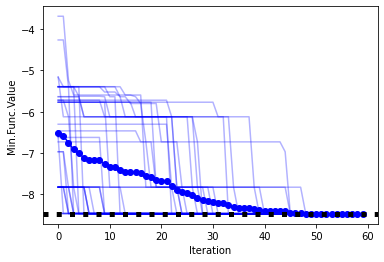

In [20]:
mean_data = df_min_y.mean()

y_min = np.nanmin(Y_all)

# 定义透明度参数
alpha_increment = 0.3 / len(df_min_y)

for i, (index, row) in enumerate(df_min_y.iterrows()):

    # 计算当前透明度
#     alpha = 0.1 + alpha_increment * (i + 1)
    alpha = 0.3
    # 绘制折线图，并设置颜色和透明度
    plt.plot(row.index, row.values, color='blue', alpha=alpha)
    
    
plt.plot(mean_data.index, mean_data.values,  marker='o', linestyle='-', color='blue')

plt.axhline(y_min, color='black', linestyle=':', linewidth=5,)
# 添加图例
# plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Min.Func.Value')

# 显示图形
plt.show()

# 保存文件

In [21]:
import os

folder_name = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\matminer\ti'
# folder_name = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\original\s2\nlcb'
# 确保文件夹存在，如果不存在则创建
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 构建完整的文件路径，包括文件夹名称和文件名
miny_name = os.path.join(folder_name, f'{file_name}_miny.xlsx')
df_min_y.to_excel(miny_name, index=False, engine='openpyxl')

wt_name = os.path.join(folder_name, f'{file_name}_wt.xlsx')
df_wt.to_excel(wt_name, index=False, engine='openpyxl')


# 画图比较

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
def remove_extreme_rows(df):
    # 找到最后一列
    last_column = df.columns[-1]
    
    drop_num = 2
    
    # 找到最大值和最小值的索引
    max_indices = df[last_column].nlargest(drop_num).index
    min_indices = df[last_column].nsmallest(drop_num).index
    
    # 删除最大值和最小值所在的行，并重置索引
    df = df.drop(max_indices).reset_index(drop=True)
    df = df.drop(min_indices).reset_index(drop=True)
    
    return df



# folder_path_1 = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\ti'
folder_name = r'C:\Users\13282\Desktop\papercode\trasfer\result\Alloy\Alloy\original\s1\nlcb'
file_path_1 = os.path.join(folder_name, 'standard_bo_miny.xlsx')    # LHS10_EI60_miny
df_sta = pd.read_excel(file_path_1)


df_tra = df_min_y 

df_sta = remove_extreme_rows(df_sta)
df_tra = remove_extreme_rows(df_tra)
# 计算均值和方差
mean_sta = df_sta.mean()
var_sta = df_sta.var()
mean_tra = df_tra.mean()
var_tra = df_tra.var()
# 创建 x 值
x1 = np.arange(len(mean_sta))
x2 = np.arange(len(mean_tra))
# 创建折线图
plt.figure(figsize=(12, 8))

# 绘制 standard-bo 折线
plt.plot(mean_sta , label='standard-bo', marker='o', linestyle='-')
# 绘制 transfer-bo 折线
plt.plot(mean_tra, label='transfer-bo', marker='s', linestyle='--')

# 计算均值加减方差的范围
std_sta = np.sqrt(var_sta)
std_tra = np.sqrt(var_tra)
upper_sta = mean_sta + std_sta
lower_sta = mean_sta - std_sta
upper_tra = mean_tra + std_tra
lower_tra = mean_tra - std_tra
# 绘制方差范围
plt.fill_between(x1, upper_sta, lower_sta, color='C0', alpha=0.6, label='std range (standard-bo)')
plt.fill_between(x2, upper_tra, lower_tra, color='C1', alpha=0.6, label='std range (transfer-bo)')

# 设置Y轴范围从0开始
# plt.ylim(0, max(upper_sta.max(), upper_tra.max()))

# 添加标题和坐标轴标签
plt.xlabel('Iterations',fontsize = 20)
plt.ylabel('Simple Regret',fontsize = 20)
plt.title('Standard VS Transfer', fontsize=20)
# 调整坐标轴参数
plt.tick_params(direction='in', length=5, width=1, labelsize=20 * 0.8, grid_alpha=0.5)
# 添加图例
plt.legend()
# 显示图形
plt.grid(True)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\13282\\Desktop\\papercode\\trasfer\\result\\Alloy\\Alloy\\original\\s1\\nlcb\\standard_bo_miny.xlsx'

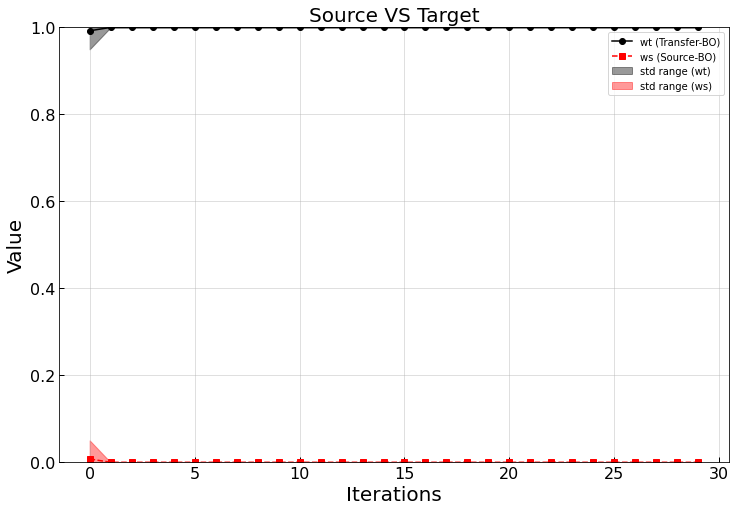

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 从 Excel 表格中导入数据
df_wt = df_wt
df_ws = 1 - df_wt  # 计算 df_ws 数据

# 计算均值和方差
mean_wt = df_wt.mean()
var_wt = df_wt.var()
mean_ws = df_ws.mean()
var_ws = df_ws.var()

# 创建 x 值
x = np.arange(len(mean_wt))

# 创建图形
plt.figure(figsize=(12, 8))

# 绘制均值折线，颜色分别设置为绿色和红色
plt.plot(x, mean_wt, label='wt (Transfer-BO)', marker='o', linestyle='-', color='black')
plt.plot(x, mean_ws, label='ws (Source-BO)', marker='s', linestyle='--', color='red')

# 计算均值加减方差的范围
std_wt = np.sqrt(var_wt)
std_ws = np.sqrt(var_ws)
upper_wt = np.clip(mean_wt + std_wt, 0, 1)  # 将范围限制在 [0, 1]
lower_wt = np.clip(mean_wt - std_wt, 0, 1)
upper_ws = np.clip(mean_ws + std_ws, 0, 1)
lower_ws = np.clip(mean_ws - std_ws, 0, 1)

# 绘制方差范围
plt.fill_between(x, upper_wt, lower_wt, color='black', alpha=0.4, label='std range (wt)')
plt.fill_between(x, upper_ws, lower_ws, color='red', alpha=0.4, label='std range (ws)')

# 设置 y 轴范围为 0 到 1
plt.ylim(0, 1)

# 添加标题和坐标轴标签
plt.xlabel('Iterations',fontsize = 20)
plt.ylabel('Value',fontsize = 20)
plt.title('Source VS Target', fontsize=20)

# 调整坐标轴参数
plt.tick_params(direction='in', length=5, width=1, labelsize=20 * 0.8, grid_alpha=0.5)

# 添加图例
plt.legend()

# 显示图形
plt.grid(True)
plt.show()
